In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from scipy import stats

# helper functions provided in helper_functions.py
from helper_functions import remove_sac_events, get_kde_dist_plots
#pip install ipynb

In [2]:
# train is the first half of season batted ball data
train = pd.read_csv('../data/raw/first_half_batted_balls.csv')
# test is the second half season SLG% for each player-season
test = pd.read_csv('../data/raw/second_half_slg.csv')

In [3]:
train

,month,season,game_id,inning,top,pa_of_inning,batter_id,bat_side,pitcher_id,pitch_side,pre_balls,pre_strikes,pre_outs,pitch_type,pitch_release_speed,pitch_spin_rate,pitch_spin_axis,pitch_tilt,pitch_release_height,pitch_release_side,pitch_extension,pitch_vert_break,pitch_induced_vert_break,pitch_horz_break,pitch_plate_height,pitch_plate_side,hit_exit_speed,hit_vert_exit_angle,hit_horz_exit_angle,hit_spin_rate,hit_distance,event_type,slg
0,5,2017,xb9d28ea4,1,1,3,x1a144c53,L,x5a365c39,R,2,2,2,Fastball,95.520002,2195.511800,197.567006,12:30,6.076918,1.131171,5.509253,-14.508357,17.015614,4.866302,2.995102,-0.624306,67.386173,-13.940554,-3.331062,NaN,12.3166,field_out,0
1,4,2017,xe759eb85,7,0,4,xbed99798,L,x74a5c086,L,1,1,2,Sinker,86.608715,2209.950094,88.530611,9:00,4.598388,-3.290455,5.827094,-36.348362,1.274052,-19.603756,2.059211,-0.866770,86.749105,-7.099422,-25.003463,NaN,13.8123,field_out,0
2,4,2017,x97331f0a,5,1,2,x1a144c53,L,x607b9354,R,1,2,0,Slider,82.602484,2347.988740,152.853349,11:00,6.079954,1.993246,5.784996,-32.741526,8.329462,-3.341363,2.658454,0.151087,97.727244,30.130697,-1.464437,2676.402803,367.1120,double_play,0
3,4,2017,x07a52b2a,3,0,7,x3c899258,R,xd7aff4b8,R,1,1,2,Fastball,94.551664,2122.917873,240.983269,2:00,6.084905,2.483645,5.427153,-22.130647,9.660908,14.986313,2.421182,-0.224985,103.634872,3.777952,-8.210238,959.542630,99.5115,single,1
4,6,2017,xbcf9f4e4,8,0,2,xbed99798,L,x7cf545bd,L,1,1,1,Slider,80.836145,2486.799467,180.682600,12:00,6.077955,-2.337797,5.600363,-31.738645,11.244203,0.112744,2.451857,-0.607118,92.305361,25.288136,16.995705,2467.164262,364.5160,field_out,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60289,6,2019,x49551477,4,1,3,x25b65d9d,R,xd55aca85,L,3,2,2,Fastball,87.999753,2044.014507,164.020086,11:30,6.353934,-1.467392,7.052112,-14.701534,19.366584,-5.555105,2.665267,-0.120858,99.071271,29.249762,-4.432223,2970.740444,395.7940,field_out,0
60290,6,2019,x49551477,4,1,3,x25b65d9d,R,xd55aca85,L,3,2,2,Undefined,87.999753,2044.014507,164.020086,11:30,6.353934,-1.467392,7.052112,-14.701534,19.366584,-5.555105,2.665267,-0.120858,99.071271,29.249762,-4.432223,2970.740444,395.7940,field_out,0
60291,4,2023,xe18a83e8,5,1,3,x39f7cd53,L,x11407bd0,R,1,1,0,Fastball,92.598658,2214.592447,197.503816,12:30,5.966697,1.744260,6.563445,-14.221122,17.448810,4.823077,3.009990,-0.991368,57.756110,57.541242,-29.627913,3651.971042,152.5200,field_out,0
60292,4,2018,x2074dabf,7,0,6,x3f3ce04e,R,xcd257028,R,0,0,2,Slider,87.487880,2562.864346,154.212156,11:15,5.697227,2.525739,5.842111,-33.082876,3.739416,-1.823453,2.415688,-0.718235,82.655458,50.925609,9.686996,4739.784020,227.1390,field_out,0


In [4]:
test

,season,batter_id,second_half_slgcon
0,2017,x7a4b2e79,0.393162
1,2017,xb96dc32c,0.468085
2,2017,xbed99798,0.323529
3,2017,x540830e0,0.418478
4,2017,x717d3ff9,0.500000
...,...,...,...
369,2023,x6f5db222,0.569536
370,2023,x8ce2668b,0.509434
371,2023,x0c97a56c,0.536082
372,2023,xae07e136,0.440789


## **Data Exploration**

From looking at the 1st-half batted ball data, there are several columns with a significant amount of missing values. We will need to handle this issue, and complete some pre-processing in preparation for modeling.

1. Run dataset summaries. Note columns with missing values, column data types, etc.

2. Explore features and their values. Check their distributions. 

3. Build a function that can calculate slugging % from a dataframe. Will be used to compare batters 1st half slugging, to their projected and actual 2nd half slugging.


From the training dataframe summary, we see there are several columns with missing values. 'hit_spin_rate' contains the most. 

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60294 entries, 0 to 60293
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   month                     60294 non-null  int64  
 1   season                    60294 non-null  int64  
 2   game_id                   60294 non-null  object 
 3   inning                    60294 non-null  int64  
 4   top                       60294 non-null  int64  
 5   pa_of_inning              60294 non-null  int64  
 6   batter_id                 60294 non-null  object 
 7   bat_side                  60294 non-null  object 
 8   pitcher_id                60294 non-null  object 
 9   pitch_side                60294 non-null  object 
 10  pre_balls                 60294 non-null  int64  
 11  pre_strikes               60294 non-null  int64  
 12  pre_outs                  60294 non-null  int64  
 13  pitch_type                59034 non-null  object 
 14  pitch_

Verifying we have the same number of unique batters in both training sets (1st and 2nd season halfs)

In [6]:
unique_batters_train = train['batter_id'].unique()
unique_batters_test = test['batter_id'].unique()
print('Unique batters: 1st half -', len(unique_batters_train), ' 2nd half -', len(unique_batters_test))

Unique batters: 1st half - 330  2nd half - 330


Checking to see which event_types exist in our dataset. When we calculate slugging % we will need to remove events such as sac bunts and sac flys since they are not considered at bats. 

In [7]:
event_types = train['event_type'].unique()
event_types

array(['field_out', 'double_play', 'single', 'sac_bunt',
       'grounded_into_double_play', 'double', 'home_run', 'sac_fly',
       'force_out', 'field_error', 'triple', 'fielders_choice',
       'triple_play', 'fielders_choice_out', 'sac_fly_double_play'],
      dtype=object)

Seeing what types of pitches exist in the data

In [8]:
pitch_counts = train['pitch_type'].value_counts()
pitch_counts

pitch_type
Fastball       24391
Slider          9569
ChangeUp        6589
Curveball       4818
Sinker          4730
Cutter          2951
Undefined       2355
Four-Seam       1774
Changeup         797
Splitter         735
Other            319
KnuckleBall        6
Name: count, dtype: int64

#### **Feature distributions:**

When we go to impute values, we will want to make sure that the distribution of a feature remains similar after imputation. The main column we should be concerned with is hit_spin_rate because 1/3 of the values for this column will be imputed. 

I took a look at several other columns, the function below will allow you to investigate other columns.

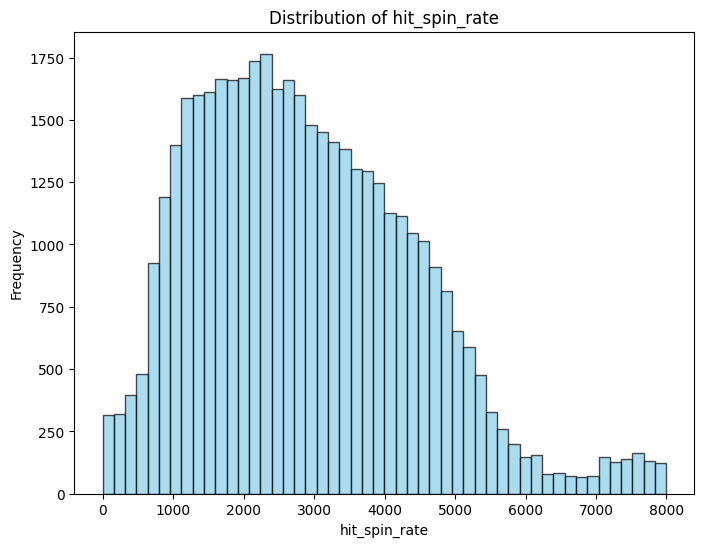

In [9]:
def get_feat_dist(df, column_name):
    plt.figure(figsize=(8, 6))
    plt.hist(df[column_name], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xlabel(f'{column_name}')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {column_name}')
    plt.show()

get_feat_dist(train, 'hit_spin_rate')

In [10]:
# example
#get_feat_dist(train, 'pitch_spin_rate')

## **Pre-Processing**: 

There are several tasks needed to clean and pre-process the data in preparation for modeling:

1. Remove plate appearances that resulted in sacrifice events (sacrifice bunts and sacrifice flys), these are not considered at bats and not included when calculating slugging. I built a function called remove_sec_events within the helper_functions.py file to do this.

2. Handle data points with pre_strikes = 3, or pre_balls = 4. There are only a few instances, but we know this is a impossible scenario, so they will be set to pre_strikes = 2 and pre_balls = 3.

3. Remove unnecessary columns that will not be used in modeling.

4. Encode categorical columns into dummy variables.

5. Impute data to replace missing (NaN) values in the dataset.

6. Ensure distribution of imputed columns matches distribution prior to imputation.

After removing sacrifice events, we should not see 'sac bunt' or 'sac fly' in the event_type values.

In [11]:
# remove sac bunts, sac flys, and sac fly double plays which are not at bats
train = remove_sac_events(train).reset_index(drop=True)
# we should not see sac events in the list below
train['event_type'].unique()

array(['field_out', 'double_play', 'single', 'grounded_into_double_play',
       'double', 'home_run', 'force_out', 'field_error', 'triple',
       'fielders_choice', 'triple_play', 'fielders_choice_out'],
      dtype=object)

Looking through the data, for some reason I noticed there are 3 instances of 60k+ rows where the count prior to the batted ball was 3 strikes or 4 balls. I don't understand how that is possible, and I'm going to assume that is an error in data collection. There are only 3 rows, so we're going to change their value to pre_balls = 3 and pre_strikes = 2. 

In [12]:
train[(train['pre_strikes'] == 3) | (train['pre_balls'] == 4)][['season', 'game_id', 'batter_id', 'pre_balls', 'pre_strikes', 'pre_outs']]

,season,game_id,batter_id,pre_balls,pre_strikes,pre_outs
3935,2019,x64c12617,xe40cc124,4,2,1
33865,2018,x5143a0a4,x8a197ef1,1,3,2
36004,2023,x43c43c93,xd02c9f0c,4,2,2


Below we see the pre_strikes and pre_balls for these rows were replaced correctly.

In [13]:
train.loc[train['pre_strikes'] == 3, 'pre_strikes'] = 2
train.loc[train['pre_balls'] == 4, 'pre_balls'] = 3
train.loc[[3935, 33865, 36004]][['season', 'game_id', 'batter_id', 'pre_balls', 'pre_strikes', 'pre_outs']]

,season,game_id,batter_id,pre_balls,pre_strikes,pre_outs
3935,2019,x64c12617,xe40cc124,3,2,1
33865,2018,x5143a0a4,x8a197ef1,1,2,2
36004,2023,x43c43c93,xd02c9f0c,3,2,2


Drop uneccesary columns: I chose to not include time-based metrics such as month, inning, pa_of_inning, game_id. At this time I did not include pitch_tilt, but may be included + interpreted in future rework of this project.

In [14]:
drop_cols = ['pitch_tilt', 'month', 'inning', 'top', 'pa_of_inning', 'game_id']
df = train.drop(drop_cols, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59364 entries, 0 to 59363
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   season                    59364 non-null  int64  
 1   batter_id                 59364 non-null  object 
 2   bat_side                  59364 non-null  object 
 3   pitcher_id                59364 non-null  object 
 4   pitch_side                59364 non-null  object 
 5   pre_balls                 59364 non-null  int64  
 6   pre_strikes               59364 non-null  int64  
 7   pre_outs                  59364 non-null  int64  
 8   pitch_type                58121 non-null  object 
 9   pitch_release_speed       59137 non-null  float64
 10  pitch_spin_rate           57585 non-null  float64
 11  pitch_spin_axis           58842 non-null  float64
 12  pitch_release_height      59137 non-null  float64
 13  pitch_release_side        59137 non-null  float64
 14  pitch_

Next we encode categorical columns into dummy variables using OneHotEncoder.

In [15]:
# saving a copy of full df
df_full = df
# dropping pitcher_id and batter_id before imputation and encoding
df = df.drop(columns=['pitcher_id', 'batter_id', 'season'])
# categorical columns that need to be encoded
categorical_columns = ['bat_side', 'pitch_side', 'pre_balls', 'pre_strikes', 'pre_outs', 'pitch_type', 'event_type']


In [16]:
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical = pd.DataFrame(encoder.fit_transform(df[categorical_columns]),
                                   columns=encoder.get_feature_names_out(categorical_columns))

# Combine encoded categorical columns with numerical columns
df_encoded = pd.concat([df.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_categorical], axis=1)

# dataframe with encoded categorical columns
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59364 entries, 0 to 59363
Data columns (total 56 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   pitch_release_speed                   59137 non-null  float64
 1   pitch_spin_rate                       57585 non-null  float64
 2   pitch_spin_axis                       58842 non-null  float64
 3   pitch_release_height                  59137 non-null  float64
 4   pitch_release_side                    59137 non-null  float64
 5   pitch_extension                       58968 non-null  float64
 6   pitch_vert_break                      59127 non-null  float64
 7   pitch_induced_vert_break              59127 non-null  float64
 8   pitch_horz_break                      59127 non-null  float64
 9   pitch_plate_height                    59147 non-null  float64
 10  pitch_plate_side                      59147 non-null  float64
 11  hit_exit_speed 

### **Imputation Approach**:

One issue that needs to be handled before we can train our models is dealing with missing values. Almost 1/3 of our entire dataset contains rows with missing values. We will want to replace these nan values with imputed values, but we want to make sure the imputed values are representative and similar to what they actually are. 

From my research, I'm aware that StatCast has been known to miss the recording of certain batted ball metrics for balls hit deeply into the ground, or pop-flys directly into the sky ([Read here](https://fivethirtyeight.com/features/mlbs-hit-tracking-tool-misses-a-lot-of-hits/)). From looking at the frequency of hit_spin_rate missing values by hit_distance below, we see that they are largely concentrated towards batted balls with low hit_distance, almost entirely < 50 feet. The article aligns with what we are seeing here with the missing data. 

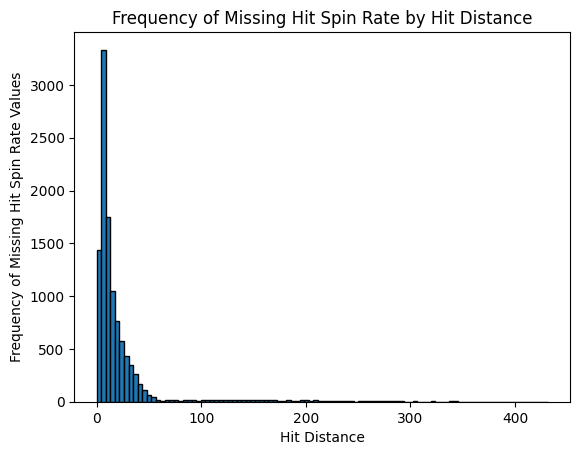

In [17]:
missing_hit_dis = train[~train['hit_distance'].isnull()]
# histogram of missing values by hit_distance
plt.hist(missing_hit_dis[missing_hit_dis["hit_spin_rate"].isnull()]["hit_distance"], bins=100, edgecolor="k")
plt.xlabel("Hit Distance")
plt.ylabel("Frequency of Missing Hit Spin Rate Values")
plt.title("Frequency of Missing Hit Spin Rate by Hit Distance")
plt.show()

Since variables such as pitch_type will have different effects on the missing values that need to be imputed, using the simple approach of a mean or mode value for imputation will not make much sense, and will not give us the best predictive power once we train our models. Additionally, we do not want to throw away rows with missing data, since there are so many.

My approach to impute these missing values is to use K-nearest-neighbor (KNN) imputer, this type of imputation considers relationships between features, capturing patterns in the data and mantaining natural variability by using data from similar observations. After performing imputation, I will check distribution and summary statistics before and after imputation to ensure accuracy.

Note: Takes 2 to 3 mins to impute using KNN Imputer(k=10)

In [18]:
# store columns and convert to numpy
df_encoded_cols = df_encoded.columns
df_encoded = df_encoded.to_numpy()
# Create a KNNImputer instance
knn_imputer = KNNImputer(n_neighbors=10)
# Impute missing values using KNNImputer
df_imputed = knn_imputer.fit_transform(df_encoded)

In [19]:
# df_i contains imputed values for columns with missing values using KNNImputer
df_i = pd.DataFrame(data=df_imputed, columns=df_encoded_cols)
# should show no missing values, 59364 non-null vals for each column
df_i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59364 entries, 0 to 59363
Data columns (total 56 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   pitch_release_speed                   59364 non-null  float64
 1   pitch_spin_rate                       59364 non-null  float64
 2   pitch_spin_axis                       59364 non-null  float64
 3   pitch_release_height                  59364 non-null  float64
 4   pitch_release_side                    59364 non-null  float64
 5   pitch_extension                       59364 non-null  float64
 6   pitch_vert_break                      59364 non-null  float64
 7   pitch_induced_vert_break              59364 non-null  float64
 8   pitch_horz_break                      59364 non-null  float64
 9   pitch_plate_height                    59364 non-null  float64
 10  pitch_plate_side                      59364 non-null  float64
 11  hit_exit_speed 

After we merge batter_id, pitcher_id and season back into the dataset, we confirm we have replaced the NaN's with imputed data, and the data is in-place correctly. 

In [20]:
#merge batter_id, pitcher_id and season back to df_encoded
df_i['batter_id'] = df_full['batter_id']
df_i['pitcher_id'] = df_full['pitcher_id']
df_i['season'] = df_full['season']

In [21]:
# rows with NaN before imputation
df_full[['season', 'batter_id', 'pitcher_id', 'pitch_spin_rate', 'pitch_release_speed', 'pitch_extension']].iloc[273:280, :]

,season,batter_id,pitcher_id,pitch_spin_rate,pitch_release_speed,pitch_extension
273,2023,x45f119fc,x95354bfe,2184.390333,95.575883,7.224659
274,2021,x078ae604,x00868f63,2212.620000,88.916300,6.606410
275,2018,x79ff9508,x8ba0da32,NaN,82.367811,4.638858
276,2017,x559cb54e,xb5aab6d9,2648.979470,90.228816,5.788850
277,2018,x8769acfc,x27238b74,2434.334797,90.307193,7.760354
278,2023,x787c164c,x0dbca028,NaN,93.582329,NaN
279,2018,x9d559f42,x96e28a21,2257.169711,94.354733,6.051832


In [22]:
# same rows after imputation
df_i[['season', 'batter_id', 'pitcher_id', 'pitch_spin_rate', 'pitch_release_speed', 'pitch_extension']].iloc[273:280, :]

,season,batter_id,pitcher_id,pitch_spin_rate,pitch_release_speed,pitch_extension
273,2023,x45f119fc,x95354bfe,2184.390333,95.575883,7.224659
274,2021,x078ae604,x00868f63,2212.620000,88.916300,6.606410
275,2018,x79ff9508,x8ba0da32,2450.008797,82.367811,4.638858
276,2017,x559cb54e,xb5aab6d9,2648.979470,90.228816,5.788850
277,2018,x8769acfc,x27238b74,2434.334797,90.307193,7.760354
278,2023,x787c164c,x0dbca028,2368.268966,93.582329,6.378906
279,2018,x9d559f42,x96e28a21,2257.169711,94.354733,6.051832


Checking distributions and summary statistics before and after imputation to ensure the imputed values are accurate. hit_spin_rate was the column that needed the largest number of imputed values (almost 20k). We need to make sure the distribution and summary statistics are similar to before imputing. 

I built a function called 'get_kde_dist_plots' within the helper_functions.py file to show the distribution, summary statistics and QQ plot before and after imputation. 

Summary Statistics - Original:
count    42078.000000
mean      2882.359708
std       1548.270076
min          0.667786
25%       1679.255618
50%       2690.592522
75%       3907.943323
max       7996.149821
Name: hit_spin_rate, dtype: float64

Summary Statistics - Imputed:
count    59364.000000
mean      2987.480204
std       1388.336188
min          0.667786
25%       2006.901395
50%       2908.799425
75%       3884.854432
max       7996.149821
Name: hit_spin_rate, dtype: float64


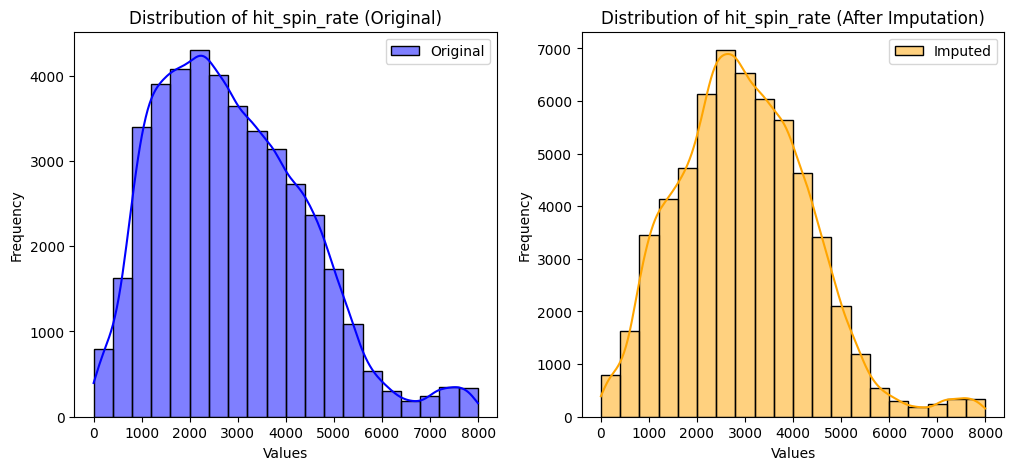

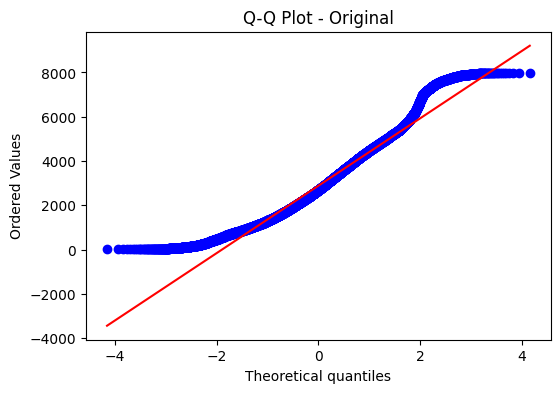

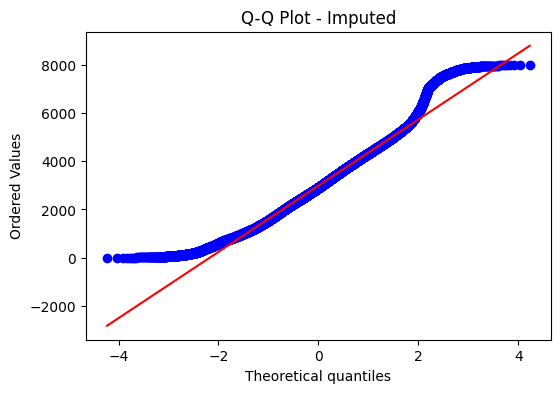

In [23]:
# can change the column below to any other feature to investigate distribution and summary statistics before and after imputing
get_kde_dist_plots(train['hit_spin_rate'], df_i['hit_spin_rate'])

#### **Explanation**

After imputing values for hit_spin_rate, we see that the distribution appears more normal, and less skewed than prior to imputation. The imputed distribution appears more normal, with a centered peak. 

The cleaned, imputed dataset will be used for modeling. 

In [24]:
# return cleaned training dataset
#df_i.to_csv("../data/processed/processed_first_half_batted_balls.csv", index=False)